In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev

import sys
sys.path.append("..")
from envs.data_handler import DataHandler, perform_ttest

# function for plotting
def plot_data(data_table, type):
    lists = data_table.groupby(['Optimal_Affected_Component', 'Optimal_Failure'])[type].apply(list).values
    fig = plt.figure(figsize=(50, 5))
    for l in lists:
        plt.hist(l, 75, alpha=0.5)
    plt.show()

dh = DataHandler()
dh.data.head()

,Optimal_Affected_Component,Optimal_Failure,untransformed,cube,sqt,log10,ln,log2
0,Query Service,CF1,49.5,5.558599,13.105330,2.234896,5.146038,7.424164
1,User Management Service,CF2,16.0,4.920383,10.914362,2.075997,4.780159,6.896312
2,Authentication Service,CF3,31.5,4.920383,10.914362,2.075997,4.780159,6.896312
3,Bid and Buy Service,CF3,25.0,4.594071,9.846831,1.986593,4.574299,6.599319
4,Item Management Service,CF3,16.0,3.559606,6.715880,1.654206,3.808950,5.495153


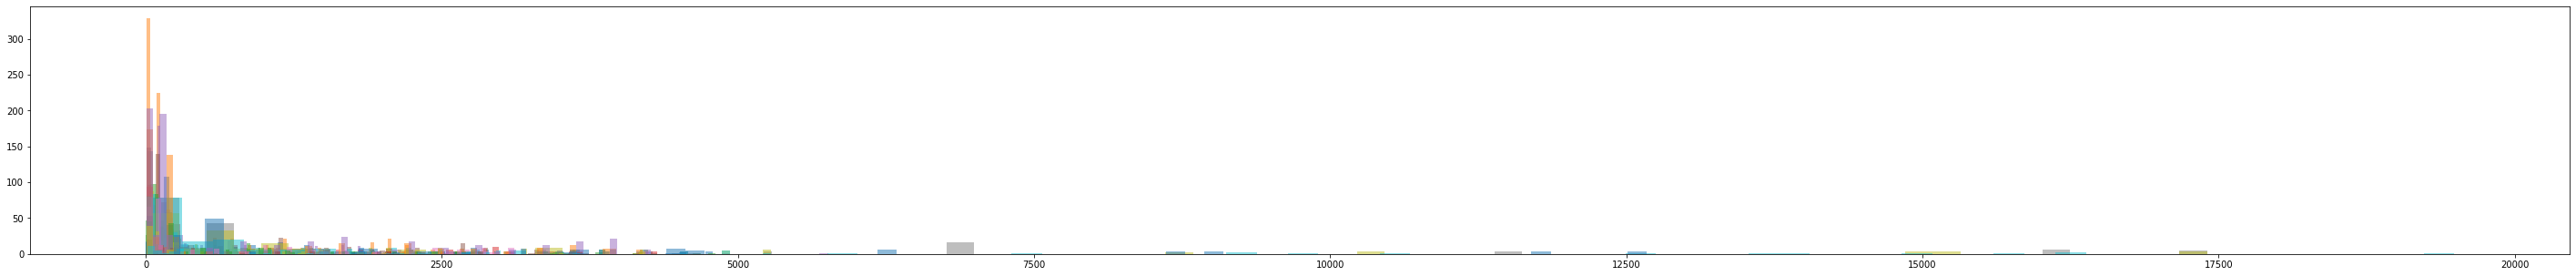

In [2]:
plot_data(dh.data, 'untransformed')

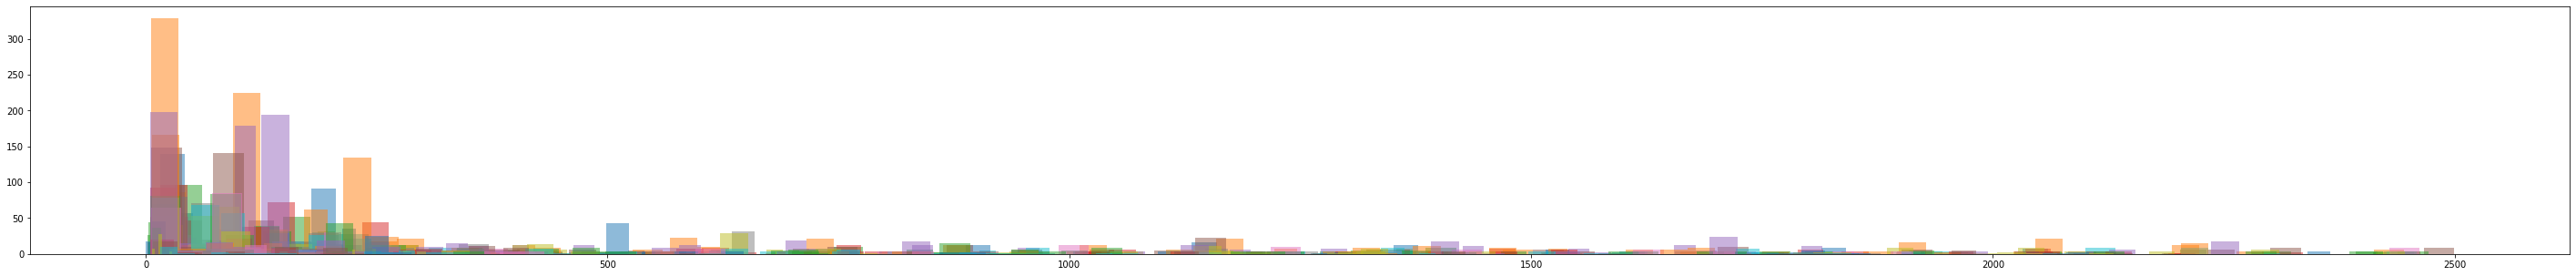

In [3]:
plot_data(dh.data[dh.data['untransformed'] < 2500], 'untransformed')

# Data Shift

## Step 1: Calculate the Standard Deviation and the mean of each <component, failure> combinations

In [4]:
mean_values = dh.data.groupby(['Optimal_Affected_Component', 'Optimal_Failure']).mean().reset_index()
stdev_values = dh.data.groupby(['Optimal_Affected_Component', 'Optimal_Failure']).std().reset_index()

## Step 2: Sort data by mean values 

In [5]:
mean_values = mean_values.sort_values(by=['untransformed'], ascending=True)

## Step 3: Iterate over data and shift it

In [6]:
data_new = dh.data.copy()

previous = None
for _, name in mean_values.iterrows():
    if previous is not None:
        pre_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component'] == previous[0]) & (stdev_values['Optimal_Failure'] == previous[1])]['untransformed'].tolist()[0]
        cur_std = stdev_values.loc[(stdev_values['Optimal_Affected_Component'] == name[0]) & (stdev_values['Optimal_Failure'] == name[1])]['untransformed'].tolist()[0]
        data_new.loc[(data_new['Optimal_Affected_Component'] == name[0]) & (data_new['Optimal_Failure'] == name[1]), 'untransformed'] += cur_std + pre_std
    previous = name
    
data_new.head()

,Optimal_Affected_Component,Optimal_Failure,untransformed,cube,sqt,log10,ln,log2
0,Query Service,CF1,8710.045827,5.558599,13.105330,2.234896,5.146038,7.424164
1,User Management Service,CF2,1726.679529,4.920383,10.914362,2.075997,4.780159,6.896312
2,Authentication Service,CF3,2183.394818,4.920383,10.914362,2.075997,4.780159,6.896312
3,Bid and Buy Service,CF3,1699.132796,4.594071,9.846831,1.986593,4.574299,6.599319
4,Item Management Service,CF3,1001.708713,3.559606,6.715880,1.654206,3.808950,5.495153


## Step 4: Analyse

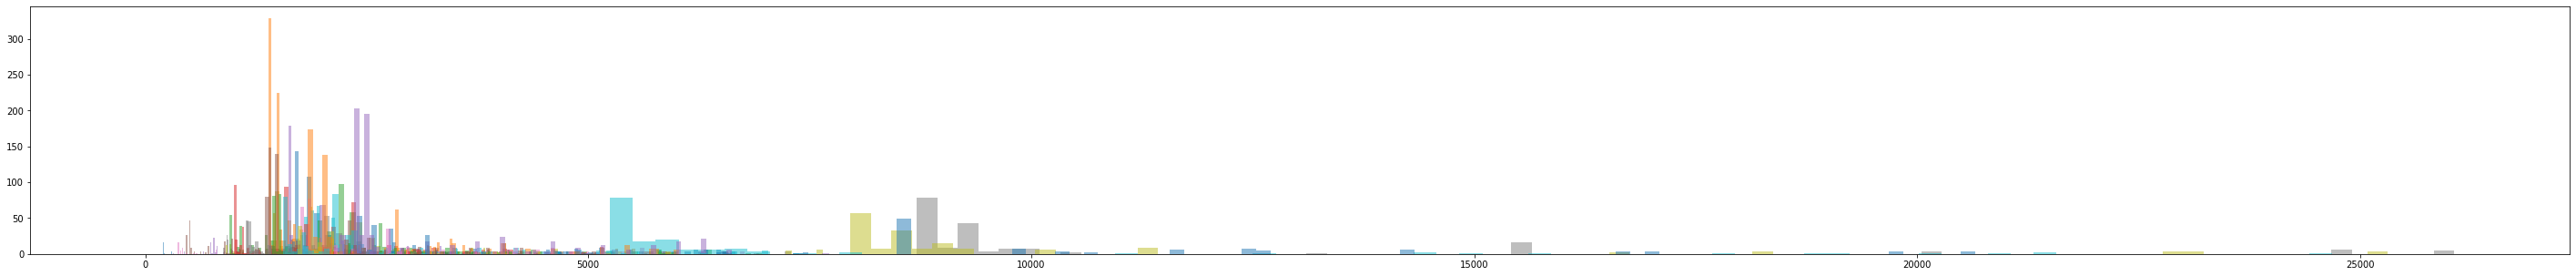

In [7]:
plot_data(data_new, 'untransformed')

## Step 5: Perform T-Test

In [8]:
result = perform_ttest(mean_values, data_new, 'untransformed')
print(len(result[result['pvalue']<0.025]), 'of the 70 <component, failure> pairs are statistical significant')

16 of the 70 <component, failure> pairs are statistical significant


# Experiment

First transform data and then shift it.

([<matplotlib.axis.XTick at 0x1a1a59de10>,
 <a list of 6 Text xticklabel objects>)

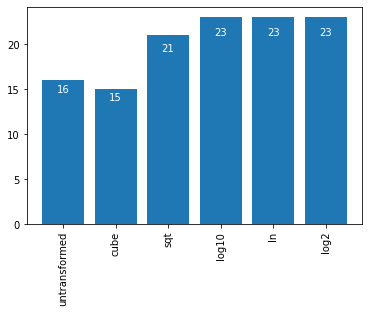

In [9]:
# x + (prestd + curstd)
types = ['untransformed','cube', 'sqt', 'log10', 'ln', 'log2']
results = []
x_ticks = range(len(types))

for t in types: 
    (means, shifted_data) = dh.shift_data(t)
    ttest = perform_ttest(means, shifted_data, t)
    results.append(len(ttest[ttest['pvalue']<0.025]))

bar_plot = plt.bar(x_ticks, results)

for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 0.9*height,results[idx],ha='center', va='bottom', rotation=0, color="white")

plt.xticks(x_ticks, types, rotation='vertical')

([<matplotlib.axis.XTick at 0x1a1cf35e90>,
 <a list of 6 Text xticklabel objects>)

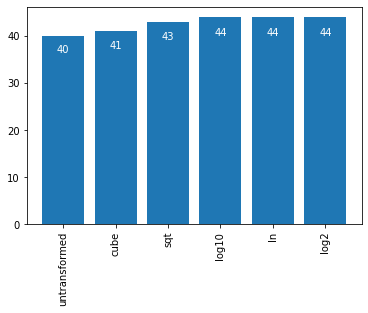

In [10]:
# x + (prestd + curstd) * 2
types = ['untransformed','cube', 'sqt', 'log10', 'ln', 'log2']
results = []
x_ticks = range(len(types))

for t in types: 
    (means, shifted_data) = dh.shift_data(t, times=2)
    ttest = perform_ttest(means, shifted_data, t)
    results.append(len(ttest[ttest['pvalue']<0.025]))

bar_plot = plt.bar(x_ticks, results)

for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 0.9*height,results[idx],ha='center', va='bottom', rotation=0, color="white")

plt.xticks(x_ticks, types, rotation='vertical')

([<matplotlib.axis.XTick at 0x1a1b787dd0>,
 <a list of 6 Text xticklabel objects>)

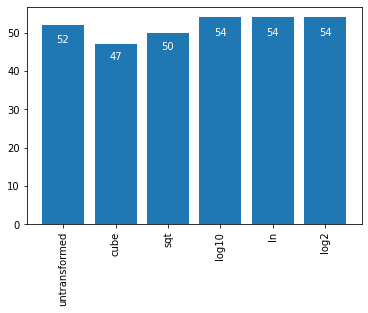

In [11]:
# x + (prestd + curstd) * 3
types = ['untransformed','cube', 'sqt', 'log10', 'ln', 'log2']
results = []
x_ticks = range(len(types))

for t in types: 
    (means, shifted_data) = dh.shift_data(t, times=3)
    ttest = perform_ttest(means, shifted_data, t)
    results.append(len(ttest[ttest['pvalue']<0.025]))

bar_plot = plt.bar(x_ticks, results)

for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 0.9*height,results[idx],ha='center', va='bottom', rotation=0, color="white")

plt.xticks(x_ticks, types, rotation='vertical')

([<matplotlib.axis.XTick at 0x1a1d2da310>,
 <a list of 6 Text xticklabel objects>)

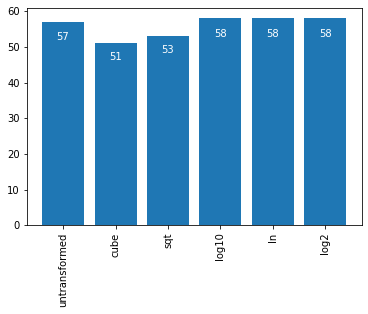

In [12]:
# x + (prestd + curstd) * 4
types = ['untransformed','cube', 'sqt', 'log10', 'ln', 'log2']
results = []
x_ticks = range(len(types))

for t in types: 
    (means, shifted_data) = dh.shift_data(t, times=4)
    ttest = perform_ttest(means, shifted_data, t)
    results.append(len(ttest[ttest['pvalue']<0.025]))

bar_plot = plt.bar(x_ticks, results)

for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 0.9*height,results[idx],ha='center', va='bottom', rotation=0, color="white")

plt.xticks(x_ticks, types, rotation='vertical')